<p style="margin: 0; text-align:right;">2022-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


### Redes neuronales recurrentes con Keras

A lo largo de esta práctica vamos a implementar varios modelos de redes neuronales recurrentes para la detección, clasificación y localización de errores en datos temporales producidos por varios sensores. 


# 0. Contexto y carga de librerias

En esta PEC vamos a utilizar redes recurrentes para trabajar con datos temporales. Los datos deberán ser descargados desde este google drive:

[<h3><center>datos</center></h3>](https://drive.google.com/drive/folders/1n-kWjxRXXd4_vRPuctFH6qQVll7kcyUH?usp=share_link)

y los guardaremos en una carpeta `/data` que estará en la carpeta raíz con el notebook. Los datos constan de la lectura de 3 sensores de monitorización.

Estos sensores no son perfectos y sistemáticamente producen lecturas erróneas. Además, están situados en un laboratorio en la novena planta de un edificio que se encuentra sobre las vías del metro, y al pasar éste por debajo deja un rastro en las lecturas de los sensores.

Nuestra tarea final es la clasificación y localización de estos defectos. Para ello, la PEC consta de varias etapas:

*   Interpretanción de los datos disponibles.
*   Creación de un modelo de clasificación basado en una RNN. Propondremos diferentes arquitecturas y deberemos escoger la que mejor _performance_ nos ofrezca. 
*   Una vez tengamos clasificados los errores los tendremos que localizar a lo largo de la sequencia temporal y para ello deberemos volver a entrenar otro modelo basado en el modelo de clasificación.
*   El producto final será una función que dada una señal de los sensores, devolverá el tipo de error, la localización de éste y un plot señalando el error.

**NOTA: se recomienda usar GPU para los entrenamientos, pero recordar las limitación de uso de GPU. Hacer los primeros test sin GPU o con muy pocos datos.**

In [1]:
import numpy as np
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import pickle
from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback

from tensorflow.keras.layers import Reshape, GlobalMaxPool1D, TimeDistributed
from tensorflow.keras.models import Model, load_model

# 1. Descarga, análisis y pre-procesado de los datos

## 1.1 Importación

Primero importamos los datos desde los ficheros `xl.pickle` y  `yl.pickle`.

In [2]:
home = '/kaggle/input/sensores/'

#with open(home+"data/xl.pickle", "rb") as f:
with open(home+"xl.pickle", "rb") as f:
    xl = pickle.load(f)
#with open(home+"data/yl.pickle", "rb") as f:
with open(home+"yl.pickle", "rb") as f:
    yl = pickle.load(f)

## 1.2 Plots

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
A partir de los datos cargados crea una función, <code>sensor_plotter</code>, para visualizar los datos indicando si tienen errores y la clase del error (1,...,5) en el título de la figura. Elige aleatoriamente 5 lecturas de sensores y visualizalos usando la función que has creado.</p>
</div>

In [3]:
def sensor_plotter(x, y):
    labels = ['Sensor 1', 'Sensor 2', 'Sensor 3']
    #Para identificar la clase de error busco la posicion de True en cada array del dataset yl
    true_indices = np.where(y)[0]
    if len(true_indices) == 0:
        plt.title('Medicion sin error')
    else:
        true_indices=true_indices+1
        if len(true_indices) == 1:
            plt.title(f"Error class number {true_indices[0]}")
        else:
            print_msg = "Error class number "
            for i in range(len(true_indices)):
                if i == len(true_indices) - 1:
                    print_msg += f"and {true_indices[i]}"
                else:
                    print_msg += f"{true_indices[i]} "
            plt.title(print_msg)


    plt.plot(x, label=labels)
    plt.legend(loc='lower left')
    plt.show()

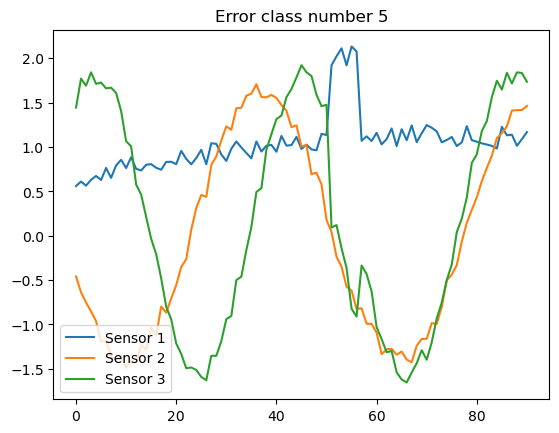

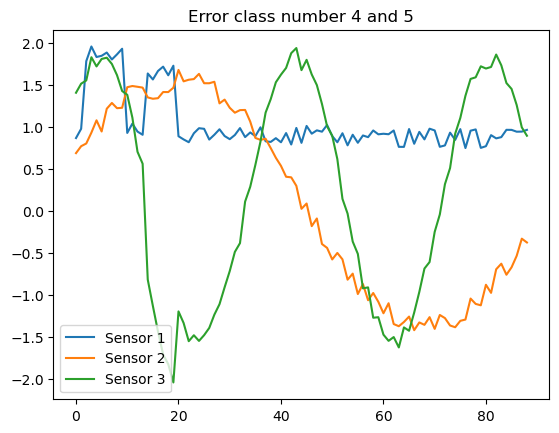

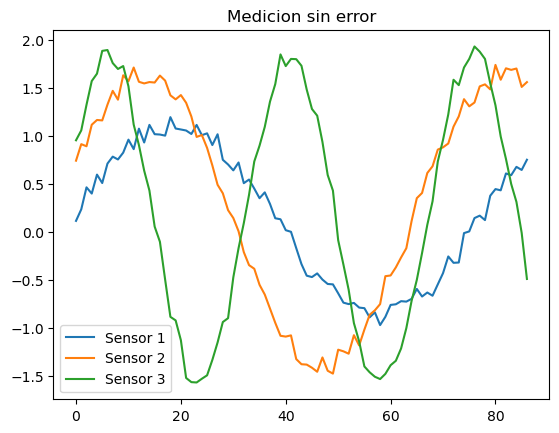

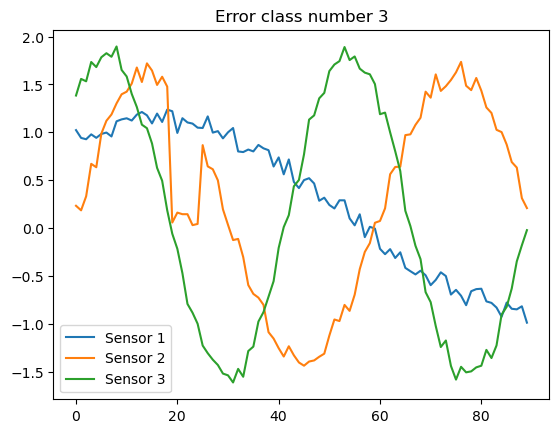

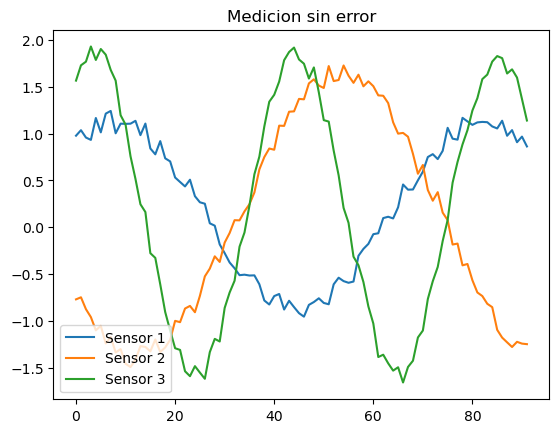

In [4]:
#Elijo cinco numeros al azar entre 0 y la longitud del array de datos para graficarlos:
np.random.seed(13) 
examples = np.random.randint(low=0, high=len(xl), size=5)
for i in examples:
    sensor_plotter(xl[i],yl[i])

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Describe los datos</strong>: tipo de funciones, diferentes tipos de errores que puedas identificar, etc...</p>
<p>
     En los gráficos 3 y 5 que son mediciones sin error podemos ver que la forma de los datos adquiridos por los sensores tienen forma sinusoidal, y las gráficas correspondientes a cada sensor están desfasadas entre ellas y tienen distinta amplitud.
    <br>
    En el gráfico número 1, vemos un caso de error de clase 5, y podemos notar un artefacto en la curva del sensor 1 y 3 al rededor del valor 50.
    <br>
   En el gráfico número 2 vemos un error de clase 4 y 5, observándolo podemos identificar un pico negativo en la curva del sensor 3 al rededor del valor 20, y también notamos un ruido a lo largo de toda la curva del sensor 1 que hace que esté aplanada y además tiene dos artefactos entre el valor 0 y el 20.
     <br>
 	En el gráfico número 4 vemos un error de clase 3, en este caso podemos identificar por un lado un artefacto negativo en la curva del sensor 2 a partir del valor 20, y por otro lado la curva del sensor 1 está estirada, es decir no vemos la forma sinusoidal que se observa en los casos de la medición sin ruido.
</p>
</div>

## 1.3 Estadísticos sobre los datos

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
Realiza un estudio estadístico básico de los datos:</p>
  <ul>
    <li> Convierte los labels booleanos en numéricos <code>False -> 0.</code> y <code>True -> 1.</code>. </li>
    <li>Probabilidad de aparición de cada tipo de error. Haz un histograma para la clase con menor probabilidad de aparición.</li>
    <li>Longitud media, máxima y mínima de las lecturas de los sensores. Haz un histograma para las longitudes y determina que tipo de distribución genera las diferentes logitudes en las lecturas de los sensores.</li>
  </ul>
</div>

In [5]:
#Usando la funcion lambda convierto los booleanos True en 1 y los False en 0:
yl = list(map(lambda each_arr: list(map(lambda x: int(x), each_arr)), yl)) #Primero mapea cada array (de cinco elementos) dentro del array principal

* Posibles salidas de la funcion yl:

Cada medición puede tener varias posibilidades, no tener ruido, tener las cinco clases de ruido juntas, o tener combinaciones de ellas, como vemos a continuación:

In [6]:
np.unique( np.array(yl), axis=0)

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 1],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 1],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 1, 1],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 1],
       [0, 1, 0, 1, 0],
       [0, 1, 0, 1, 1],
       [0, 1, 1, 0, 0],
       [0, 1, 1, 0, 1],
       [0, 1, 1, 1, 0],
       [0, 1, 1, 1, 1],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 1, 0],
       [1, 0, 0, 1, 1],
       [1, 0, 1, 0, 0],
       [1, 0, 1, 0, 1],
       [1, 0, 1, 1, 0],
       [1, 0, 1, 1, 1],
       [1, 1, 0, 0, 0],
       [1, 1, 0, 0, 1],
       [1, 1, 0, 1, 0],
       [1, 1, 0, 1, 1],
       [1, 1, 1, 0, 0],
       [1, 1, 1, 0, 1],
       [1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1]])

In [7]:
#Probabilidad de aparicion de cada tipo de error:
n = len(yl)
cant_errores = [0, 0, 0, 0, 0] #Array que va a contener la cantidad de veces que aparece cada errror

for item in yl:
    for i in range(5):
        if item[i] == 1:
            cant_errores[i] += 1

probabilidades = [error / n for error in cant_errores]

for i in range(5):
    print('Error clase ',i+1,'probabilidad: ',round(probabilidades[i],3))

Error clase  1 probabilidad:  0.178
Error clase  2 probabilidad:  0.269
Error clase  3 probabilidad:  0.102
Error clase  4 probabilidad:  0.327
Error clase  5 probabilidad:  0.458


In [8]:
menor_prob = min(probabilidades)
tipo_error_min_prob = probabilidades.index(menor_prob)

print('La clase de error con menor probabilidad de aparicion es la número:',tipo_error_min_prob+1)

La clase de error con menor probabilidad de aparicion es la número: 3


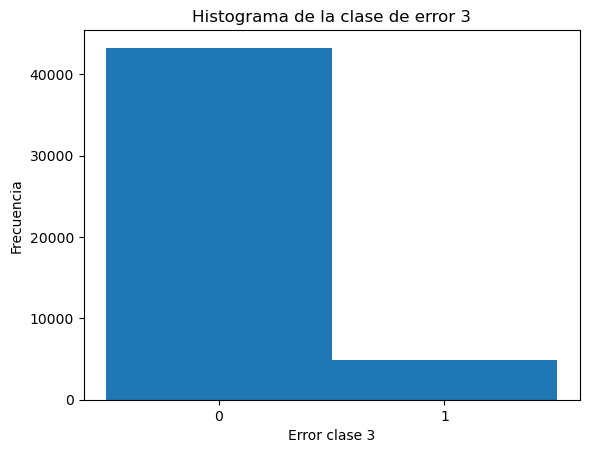

In [9]:
hist_data = [sublist[tipo_error_min_prob] for sublist in yl] #Array con los valores correspondiente a la posicion que indica si hubo o no error de clase 3
plt.hist(hist_data, bins=[-0.5,0.5,1.5], align='mid')
plt.xticks([0,1])
plt.xlabel(f'Error clase {tipo_error_min_prob+1}')
plt.ylabel('Frecuencia')
plt.title('Histograma de la clase de error 3')
plt.show()

In [10]:
longitud_medidas = [len(subarray) for subarray in xl]
promedio_medidas = round(sum(longitud_medidas) / len(longitud_medidas))
max_medida = max(longitud_medidas)
min_medida = min(longitud_medidas)

print("Promedio:", promedio_medidas)
print("Maximo:", max_medida)
print("Minimo:", min_medida)

Promedio: 90
Maximo: 101
Minimo: 78


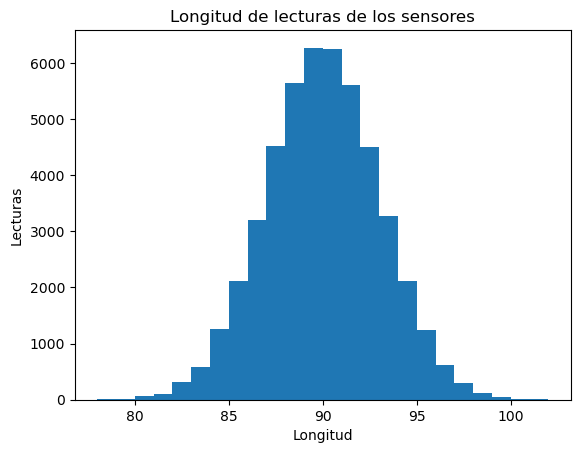

In [11]:
plt.hist(longitud_medidas, bins=range(min(longitud_medidas), max(longitud_medidas) + 2))
plt.title("Longitud de lecturas de los sensores")
plt.xlabel("Longitud")
plt.ylabel("Lecturas")
plt.show()

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Comentarios:</strong></p>
    <p> 
     Tras calcular las probabilidades de los distintos tipos de error vemos que el que menor ocurrencia presenta en la muestra es el error de tipo 3, siendo el de tipo 5 el que más se presenta.
   <br>
   En promedio, los senores realizaron 90 lecturas, siendo el valor máximo 101 lecturas y el mínimo 78. 
    <br>
   En cuanto a la distribución de las longitudes vemos que en el histograma se ha formado una curva con forma de campana de Gauss o normal, vemos que la mayoría de las lecturas se centran en la longitud de 90 y para ambos lados la campana tiene la misma forma. 

</p>
</div>

## 1.4 Uniformizando la longitud de los datos

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
Dado que las lecturas de los sensores tiene longitudes variables, necesitamos estandarizarlas. Para esta sección, hay varias opciones pero empezaremos por la más sencilla:</p>
  <ul>
    <li>Las lecturas con tiempos mayores a la media, las cortaremos.</li>
    <li>Las lecturas con tiempos menores a las medias, las completaremos con el valor médio de cada sensor.</li>
  </ul>
<p>Después de este proceso, elige un caso de tiempo mayor y uno menor y visualizalos usando la función <code>sensor_plotter</code>.</p>
</div>

In [12]:
#Cortamos las lecturas con tiempos mayores a la media:
xl_2 = xl.copy()
for i in range(len(xl)):
     if len(xl[i]) > promedio_medidas:
            xl[i] = xl[i][:promedio_medidas]

In [13]:
#Calculo el valor medio de cada sensor:

sensor1 = []
sensor2 = []
sensor3 = []

# Itero sobre los datos
for sensor_data in xl:
    # itero sobre las mediciones de cada sensor:
    for measure in sensor_data:
        # agrego las mediciones de cada sensor a su lista correspondiente
        sensor1.append(measure[0])
        sensor2.append(measure[1])
        sensor3.append(measure[2])

        
# calculo el valor medio de mediciones para cada sensor
sensor1_mean = sum(sensor1) / len(sensor1)
sensor2_mean = sum(sensor2) / len(sensor2)
sensor3_mean = sum(sensor3) / len(sensor3)

# Muestro valores
print("Sensor 1, valor medio:", sensor1_mean)
print("Sensor 2, valor medio:", sensor2_mean)
print("Sensor 3, valor medio:", sensor3_mean)

Sensor 1, valor medio: 0.4991213569047704
Sensor 2, valor medio: 0.1275986720113486
Sensor 3, valor medio: 0.2045843535977179


In [14]:
media_sensores = [round(sensor1_mean,2),round(sensor2_mean,2), round(sensor3_mean,2)]

for i, data in enumerate(xl):
    if len(data) < promedio_medidas: #Si la longitud de las mediciones no llegan al promedio entonces agrego las medias
        # Cantidad de arrays de media que tengo que agregar:
        size = promedio_medidas - len(data)
        # Creo un array de size arrays (calculados arriba) con los valores medios de los sensores
        array_to_add = np.tile(media_sensores, (size, 1))
        # Concateno los arrays a los datos de esa medición:
        xl[i] = np.concatenate((array_to_add, data), axis=0)
     

**Ejemplo de caso de longitud menor a la media**

In [15]:
print('Longitud original de la muestra 3:',len(xl_2[3]),'\nLongitud modificada de la muestra 3: ', len(xl[3]))

Longitud original de la muestra 3: 89 
Longitud modificada de la muestra 3:  90


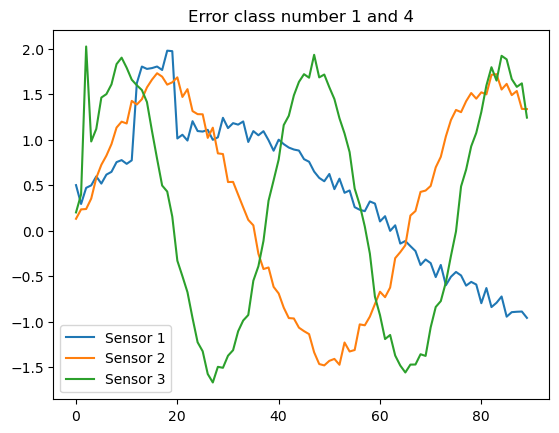

In [16]:
sensor_plotter(xl[3],yl[3])

**Ejemplo de caso de longitud mayor a la media**

In [17]:
print('Longitud original de la muestra 1:',len(xl_2[1]),'\nLongitud modificada de la muestra 1: ', len(xl[1]))

Longitud original de la muestra 1: 93 
Longitud modificada de la muestra 1:  90


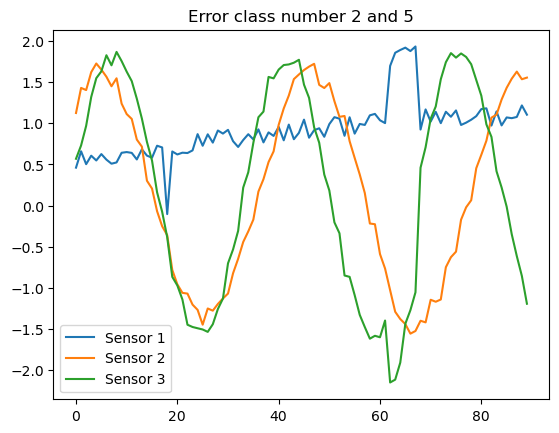

In [18]:
sensor_plotter(xl[1],yl[1])

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Comenta que tipo de problemas puede conllevar este proceso</strong>. ¿Propondrías otro método para uniformizar los datos?</p>
<p>
    Este proceso podría conllevar distintos problemas como por ejemplo pérdida de información valiosa en el caso del recorte de los datos cuando son mayores a la longitud media, o al incorporar el valor medio de las lecturas cuando la longitud de la medición es menor que el promedio, porque estamos asumiendo que todas esas mediciones nulas tendrían el mismo valor. 
<br> 
    Al completar los valores con el valor medio de las lecturas podríamos estar introduciendo sesgo en los datos, ya que puede darse el caso en el cual el valor medio no represente correctamente a todas las mediciones. 
<br>
    Otro método que se podría probar para estandarizar las mediciones puede ser utilizando técnicas más sofisticadas que tengan en cuenta más características al momento de rellenar un valor pérdido, como por ejemplo interpolación lineal, usar un modelo de k vecinos más cercanos, imputación múltiple en la cual se utilizan distintos métodos de imputación y luego de combinan para obtener una estimación única final.
</p>
</div>

In [19]:
# Indica las dimensiones de los datos y los labels
print('Dimensiones de los datos:\nCantidad de lecturas:', len(xl),
     '\nCantidad de mediciones en cada lectura:', len(xl[0]),
     '\nCantidad de datos por medicion:', len(xl[0][0]),
      ', cada uno representa un sensor')

print('\nDimensiones de los labels:\nCantidad de lecturas:', len(yl),
     '\nCantidad de datos en cada lectura:', len(yl[0]),
    ', cada una representa una clase de error')

Dimensiones de los datos:
Cantidad de lecturas: 48159 
Cantidad de mediciones en cada lectura: 90 
Cantidad de datos por medicion: 3 , cada uno representa un sensor

Dimensiones de los labels:
Cantidad de lecturas: 48159 
Cantidad de datos en cada lectura: 5 , cada una representa una clase de error


## 1.5 Data split para clasificación

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">

    Antes de empezar con la construcción de un modelo de clasificación, realizaremos una partición (split) de los datos en 3 grupos:
  <ul>
    <li> 80% para entrenamiento: <code>x_train</code></li>
    <li> 10% para validacion: <code>x_val</code></li>
    <li> 10% para testeo <code>x_test</code></li>
  </ul>
<p>y un <i>shuffle</i> de cada conjunto.</p>
</div>

In [20]:
#Normalizo los datos antes del split:
from sklearn.preprocessing import StandardScaler

data_array = np.array(xl)
# Reshape the data
n_samples, n_rows, n_cols = data_array.shape
data_array = data_array.reshape(n_samples, n_rows * n_cols)

# Normalize using StandardScaler:
scaler = StandardScaler()

xl = scaler.fit_transform(data_array)

In [21]:
xl.shape

(48159, 270)

In [22]:
from sklearn.model_selection import train_test_split

#Split de los datos y los labels en un conjunto de train (0,8) y un conjunto de test (0,2)
x_train, x_test, y_train, y_test = train_test_split(xl, yl, test_size=0.2, shuffle=True)
#Otro split de los datos y los labels del set de test en dos conjuntos: uno de test (0,1) y otro de validacioin (0,1)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, shuffle=True)

In [23]:
# Convierto los datos en arrays de Numpy:
X_train = np.array(x_train)
X_val = np.array(x_val)
X_test = np.array(x_test)

Y_train = np.array(y_train)
Y_val = np.array(y_val)
Y_test = np.array(y_test)

# Reshape para que tengan la forma correspondiente:
X_train = X_train.reshape(X_train.shape[0], 90, 3)
X_val = X_val.reshape(X_val.shape[0], 90, 3)
X_test = X_test.reshape(X_test.shape[0], 90, 3)

In [24]:
print(X_train.shape, Y_train.shape)

(38527, 90, 3) (38527, 5)


In [25]:
print(X_val.shape, Y_val.shape)

(4816, 90, 3) (4816, 5)


In [26]:
print(X_test.shape, Y_test.shape)

(4816, 90, 3) (4816, 5)


In [27]:
# Definimos el número de sensores de los que disponemos y el número de clases (tipos de errores)
n_sensores = (90, 3)
n_clases = 5

## 2.1 Callbacks

Una vez tenemos los datos preparados y entendemos mejor el conjunto de datos del que disponemos, podemos empezar a testear diferentes arquitecturas para la clasificación de los tipos de errores. 

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
Primero, crearemos un callback propio para conocer el tiempo utilizado en el entrenamiento ya que lo usaremos también como métrica a la hora de escoger la arquitectura final de la red de clasificación.</p>
</div>

In [28]:
import time

class TimerCallback(Callback):
        
    def on_train_begin(self, logs=None):
        self.start_time = time.time()
        self.epoch_times = []
    
    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.start_time
        self.epoch_times.append(epoch_time)
    
    def on_train_end(self, logs=None):
        total_time = time.time() - self.start_time
        self.total_time = total_time
        print(f"\nTiempo total de entranamiento: {total_time:.2f} segundos")


Además, usaremos la siguiente clase para visualizar las métricas durante el _fit_ de los modelos:

In [29]:
#------------------------------#
#     NO TOCAR ESTA CLASE      #
#------------------------------#

class PlotLearning(Callback):
    """
    Callback para plotear las métricas durante el entrenamiento.
    """
    def __init__(self, showLR=False):
      self.showLR = showLR                   # podemos elegir si mostrar o no el plot del learning rate en cada epoch

    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        metric = [x for x in logs if ('val' not in x) and ('lr' not in x)]
        if self.showLR:
          metric.append('lr')
        
        f, axs = plt.subplots(1,len(metric),figsize=(10,4))
        clear_output(wait=True)
        for i,ax in enumerate(axs):
          ax.plot(range(1, epoch + 2), self.metrics[metric[i]],'o--',label=metric[i])
          try:
            ax.plot(range(1, epoch + 2), self.metrics['val_' + metric[i]], 'o--', label='val_' + metric[i])
          except:
            pass
          ax.set_xlabel('# epochs')
          ax.set_ylabel(metric[i])
          ax.legend()
          ax.grid()

        plt.tight_layout()
        plt.show()

## 2.2 SimpleRNN Layer

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
El primer paso será construir un modelo, <code>simpleRNN_model</code>, basado en un único _layer_ <code>SimpleRNN</code> para tener un primer modelo base con el que comparar:</p>
  <ul>
    <li><code>SimpleRNN</code> con <code>units = 128</code>.</li>
    <li>La capa final será una cada densa con tantos nodos como clases tenemos.</li>
  </ul>
<p>El output de la capa densa la interpretaremos como una probabilidad, por lo que es necesario escoger correctamente la función de activación y justificar su elección. Además, utilizaremos <code>Adam</code> como optimizador y la función de <i>loss</i> deberá ser la adecuada teniendo en cuenta la tarea que llevamos a cabo.</p>
</div>

**NOTA**: 
- Se recomienda, al final de la creación de cada modelo, utilizar la función `summary()` para comprobar la estructura de la red creada, así como el numero de parámetros que se deben entrenar. Se recomienda hacerlo en todos los ejercicios.

In [30]:
#Definicion del modelo
simpleRNN_model = Sequential()
simpleRNN_model.add(SimpleRNN(128, activation='sigmoid', input_shape=(90,3)))
simpleRNN_model.add(Dense(5, activation='sigmoid'))

# Compilo el modelo
simpleRNN_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['binary_accuracy'])

simpleRNN_model.summary()
trainable_params_simpleRNN = simpleRNN_model.count_params()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 128)               16896     
                                                                 
 dense (Dense)               (None, 5)                 645       
                                                                 
Total params: 17,541
Trainable params: 17,541
Non-trainable params: 0
_________________________________________________________________


La función de activación es una función sigmoidea debido a que, por un lado, estamos frente a un problema de clasificación entre múltiples clases que NO son mutuamente excluyentes, sino que cada medición puede contener ninguno, uno o más errores (por esta razón no usamos softmax), la función de activación sigmoidea no asume que las salidas son mutuamente excluyentes porque activa independientemente cada nodo de salida, permitiendo que cada nodo tenga un valor entre 0 y 1 independientemente de los otros nodos de salida. Esto la hace adecuada para problemas de clasificación de etiquetas múltiples donde cada muestra puede pertenecer a varias clases al mismo tiempo. Por otro lado porque la salida de esa función puede interpretarse como una distribución de probabilidad, es decir a la salida vamos a obtener la probabilidad de que el input corresponda a cada clase.

Con respecto a la función de loss elegida es binary-cross-entropy debido a que es adecuada para trabajar en problemas de clasificación entre múltiples clases donde la salida del modelo es la distribución de probabilidades entre las distintas clases.
La métrica tambien es binaria (binary_accuracy) debido a que los labels están conformados por los valores 0 y 1.

#### Entrenamiento

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
Entrenaremos por 100 epochs con <code>batch_size = 256</code> y usando los siguientes callbacks:</p>
  <ul>
    <li>  TimerCallback (ver apartado 2.1)</li>
    <li>  PlotLearning (ver apartado 2.1)</li>
    <li>  EarlyStopping con una persistencia de 5 epochs</li>
    <li>  ReduceLROnPlateau con una persistencia de 5 epochs y monitorizando la <code>loss</code></li>
  </ul>
<p>Al finalizar el entreamiento:</p>
<ul>
    <li>  Realizar la evaluación del modelo y mostrar la <code>loss</code> y la <code>accuracy</code> final sobre los datos de test.</li>
    <li>  Realiza un plot del tiempo para cada epoch y calcula el tiempo total de entrenamiento con la información almacenada en el <code>TimerCallback</code> que has definido. </li>
  </ul>
</div>

**NOTAS**: 
- Se recomienda hacer una función que imprima esta gráfica para poder reutilizarla en próximos apartados.
- Se recomienda SIEMPRE guardar los modelos una vez entrenados, pero es muy importante si trabajáis con entornos como Colab que os cierra las sesiones.
- Los timepos los necesitaremos luego, por lo que puede ser una buena idea también guardar los resultados de tiempos para cada epoch.

In [31]:
#Defino los callbacks:
timer_callback = TimerCallback()
plot_callback = PlotLearning()
earlystop_callback = EarlyStopping(monitor='loss', patience=5)
lrreduce_callback = ReduceLROnPlateau(monitor='loss', patience=5)

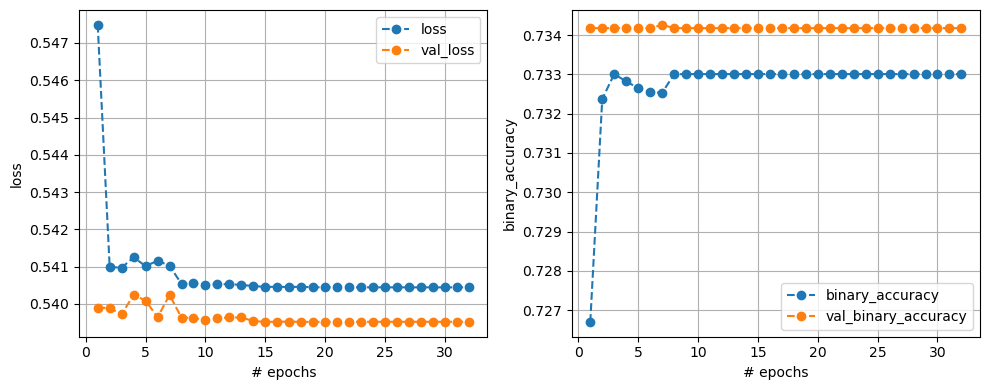

151/151 [==============================] - 12s 81ms/step - loss: 0.5404 - binary_accuracy: 0.7330 - val_loss: 0.5395 - val_binary_accuracy: 0.7342 - lr: 1.0000e-08

Tiempo total de entranamiento: 405.70 segundos


In [32]:
#Entreno el modelo:
history_simpleRNN = simpleRNN_model.fit(X_train, Y_train, batch_size=256, epochs=100,
                              validation_data=(X_val, Y_val), 
                              callbacks=[timer_callback, plot_callback, earlystop_callback, lrreduce_callback])


In [33]:
epochs_trained_RNN = len(history_simpleRNN.history['loss'])

In [34]:
# Evaluo el modelo con los datos de test:
loss_simpleRNN, acc_simpleRNN = simpleRNN_model.evaluate(X_test, Y_test)
print(f"Test loss: {loss_simpleRNN:.4f}, Test accuracy: {acc_simpleRNN:.4f}")

151/151 [==============================] - 1s 10ms/step - loss: 0.5412 - binary_accuracy: 0.7326
Test loss: 0.5412, Test accuracy: 0.7326


In [35]:
# Plot para cada epoca del entrenamiento de la red:
def plot_epoch_times(timer_callback):
    times = timer_callback.epoch_times
    plt.plot(range(1, len(times)+1), times, 'bo-', label='Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Time (s)')
    plt.legend()
    plt.title('Tiempo para cada epoch')
    plt.show()

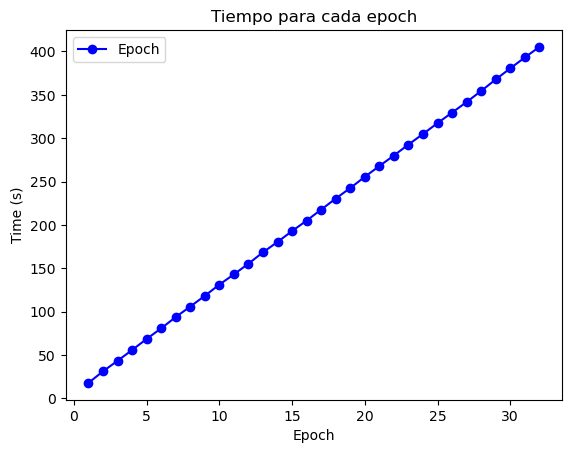

Tiempo total de training: 405.7 segundos


In [36]:
plot_epoch_times(timer_callback)

# Tiempo total del training:
tiempo_total_simpleRNN = round(timer_callback.total_time,2)
print(f"Tiempo total de training: {tiempo_total_simpleRNN} segundos")

# Guardo el modelo
simpleRNN_model.save('simpleRNN_model.h5')

El gráfico muestra el tiempo que le lleva al modelo completar cada época, y vemos como el tiempo crece de forma lineal a medida que las épocas se incrementan, lo cual es esperable ya que el modelo aprende cada vez más características de los datos. 

## 2.3 GRU layer

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
En este apartado replicaremos el modelo anterior, pero ahora cambiando el layer <code>SimpleRNN</code> por un layer <code>GRU</code> para comparar el rendimiento y el tiempo de entrenamiento. En este caso utilizaremos 64 unidades en lugar de 128 para mantener el número de parámetros y el tiempo de entrenamiento bajos.</p>
<p>Comenta los resultados:</p>
<ul>
    <li>  ¿Mejora el rendimiento general?</li>
    <li>  ¿Aumenta el tiempo de entrenamiento? ¿Y el número de parámetros entrenables?</li>
    <li>  ¿Cúal funciona mejor? ¿Por qué crees que sucede esto?</li>
  </ul>
</div>

In [37]:
#Definicion del modelo:
gru_model = Sequential()
gru_model.add(GRU(units=64,activation = 'tanh',recurrent_activation='sigmoid', input_shape=(90,3)))
gru_model.add(Dense(5, activation='sigmoid'))

# Compilo el modelo
gru_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['binary_accuracy'])

gru_model.summary()
trainable_params_gru = gru_model.count_params()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                13248     
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 13,573
Trainable params: 13,573
Non-trainable params: 0
_________________________________________________________________


In [38]:
#Defino los callbacks:
timer_callback = TimerCallback()
plot_callback = PlotLearning()
earlystop_callback = EarlyStopping(monitor='loss', patience=5)
lrreduce_callback = ReduceLROnPlateau(monitor='loss', patience=5)

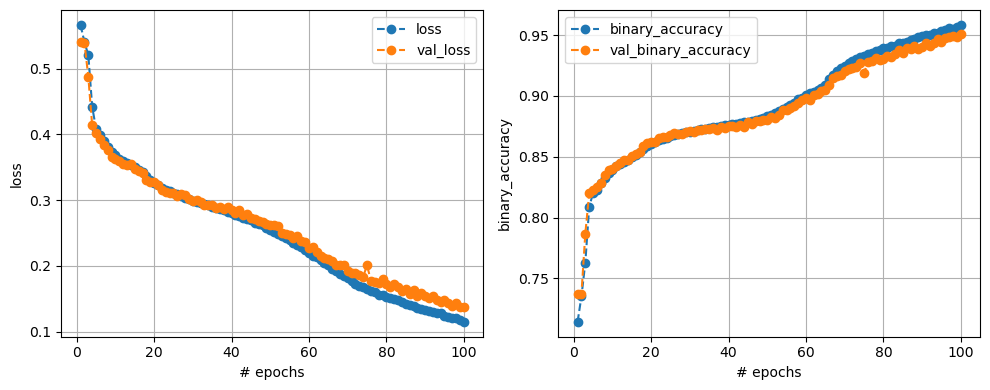

151/151 [==============================] - 2s 11ms/step - loss: 0.1149 - binary_accuracy: 0.9584 - val_loss: 0.1369 - val_binary_accuracy: 0.9507 - lr: 0.0010

Tiempo total de entranamiento: 177.26 segundos


In [39]:
#Entreno el modelo:
history_gru = gru_model.fit(X_train, Y_train, batch_size=256, epochs=100,
                              validation_data=(X_val, Y_val), 
                              callbacks=[timer_callback, plot_callback, earlystop_callback, lrreduce_callback])

In [40]:
epochs_trained_gru = len(history_gru.history['loss'])

In [41]:
# Evaluo el modelo con los datos de test:
loss_gru, acc_gru = gru_model.evaluate(X_test, Y_test)
print(f"Test loss: {loss_gru:.4f}, Test accuracy: {acc_gru:.4f}")

151/151 [==============================] - 1s 5ms/step - loss: 0.1323 - binary_accuracy: 0.9511
Test loss: 0.1323, Test accuracy: 0.9511


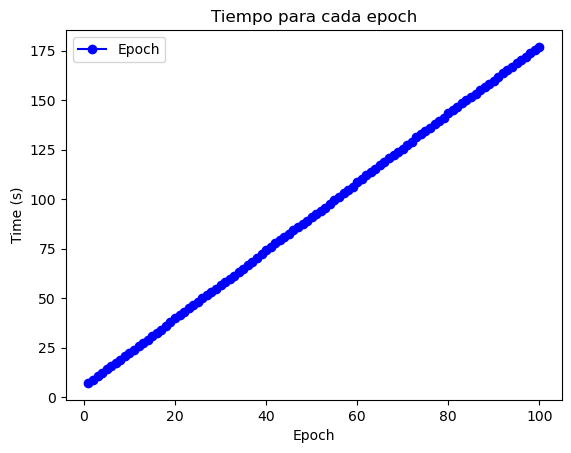

Tiempo total de training: 177.26 segundos


In [42]:
#Grafico del tiempo por las epocas:
plot_epoch_times(timer_callback)

# Tiempo total del training:
tiempo_total_gru = round(timer_callback.total_time,2)
print(f"Tiempo total de training: {tiempo_total_gru} segundos")

# Guardo el modelo
gru_model.save('gru_model.h5')

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Comentarios:</strong></p>
<p>
    El rendimiento del modelo mejora con el modelo GRU: Gated Recurrent Unit en comparación con el modelo simpleRNN. El accuracy pasó de 0.73 a 0.96. 
    <br>
El tiempo de entrenamiento se redujo y la cantidad de épocas ha aumentado al máximo valor seteado,que es 100, por lo tanto entendemos que el tiempo de entrenamiento de cada época es menor en el modelo GRU que en el simple RNN. 
    <br>
La cantidad de parámetros entrenadles también se redujeron en el modelo GRU, pasando de 17541 en el simple RNN a 13573, esto colabora a que el tiempo de entrenamiento haya bajado.
    <br>
El modelo GRU funciona mejor que el simple RNN porque a pesar de que ambas son redes neuronales recurrentes, su principal diferencia es que las redes GRU tienen un mecanismo de control del flujo de información a través de neuronas que actúan como puertas, las cuales dejan pasar más o menos información hacia la memoria de la red.
    <br>
Entonces, es posible que el modelo GRU funcione mejor que el modelo simple RNN porque ha podido capturar mejor las dependencias en los datos de entrada. Además, las redes GRU tienen menos parámetros a entrenar lo cual hace que sean menos propensas al overfitting y también contribuye al mejor rendimiento del modelo.
</p>
</div>

### 2.3.1 Incrementando la capacidad de nuestro modelo

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
En esta sección intentaremos incrementar la capacidad de nuestro modelo y, para ello, en lugar de añadir unidades, aumentaremos la profundidad, sumando otra capa GRU. Esta nueva capa recibirá la sequencia de la capa anterior y tendrá la mitad de unidades.</p>
    <p>Comenta los resultados de rendimiento en <i>accuracy</i> y en tiempo.</p>
</div>

In [43]:
#Defino el modelo:
gru_model2 = Sequential()
gru_model2.add(GRU(units=64,activation = 'tanh', recurrent_activation= 'sigmoid', input_shape=(90,3), return_sequences=True))
gru_model2.add(GRU(units=32,activation = 'tanh', recurrent_activation= 'sigmoid'))
gru_model2.add(Dense(units=5, activation='sigmoid'))

gru_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['binary_accuracy'])
gru_model2.summary()
trainable_params_gru2 = gru_model2.count_params()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 90, 64)            13248     
                                                                 
 gru_2 (GRU)                 (None, 32)                9408      
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                                 
Total params: 22,821
Trainable params: 22,821
Non-trainable params: 0
_________________________________________________________________


In [44]:
#Defino los callbacks:
timer_callback = TimerCallback()
plot_callback = PlotLearning()
earlystop_callback = EarlyStopping(monitor='loss', patience=5)
lrreduce_callback = ReduceLROnPlateau(monitor='loss', patience=5)

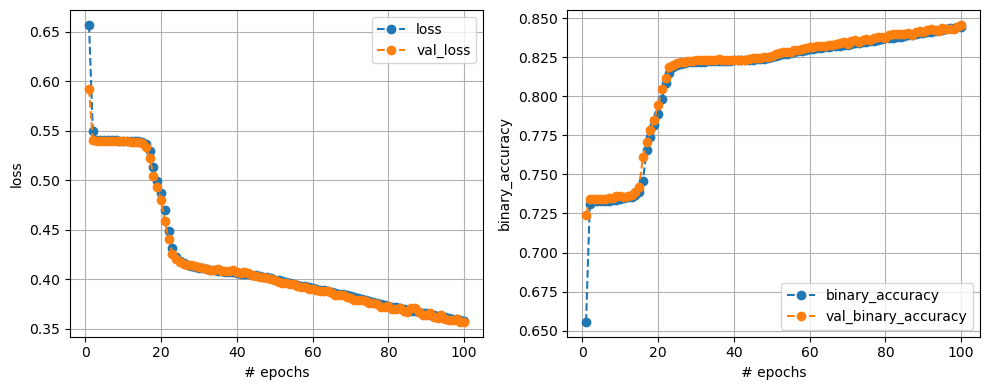

151/151 [==============================] - 3s 18ms/step - loss: 0.3576 - binary_accuracy: 0.8447 - val_loss: 0.3569 - val_binary_accuracy: 0.8458 - lr: 1.0000e-04

Tiempo total de entranamiento: 236.97 segundos


In [45]:
#Entreno el modelo:
history_gru2 = gru_model2.fit(X_train, Y_train, batch_size=256, epochs=100,
                              validation_data=(X_val, Y_val), 
                              callbacks=[timer_callback, plot_callback, earlystop_callback, lrreduce_callback])

In [46]:
epochs_trained_gru2 = len(history_gru2.history['loss'])

In [47]:
# Evaluo el modelo con los datos de test:
loss_gru2, acc_gru2 = gru_model2.evaluate(X_test, Y_test)
print(f"Test loss: {loss_gru2:.4f}, Test accuracy: {acc_gru2:.4f}")

151/151 [==============================] - 1s 6ms/step - loss: 0.3590 - binary_accuracy: 0.8479
Test loss: 0.3590, Test accuracy: 0.8479


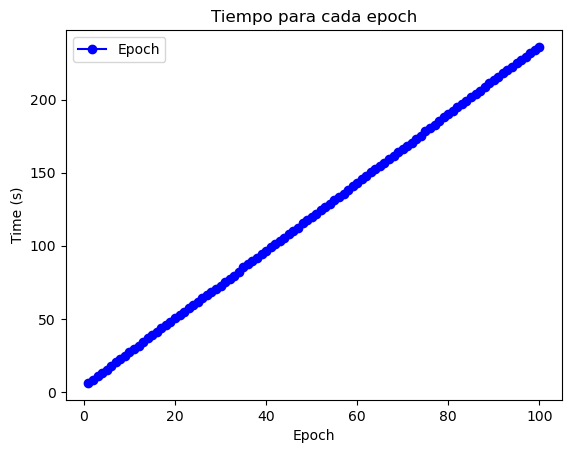

Tiempo total de training: 236.97 segundos


In [48]:
#Grafico del tiempo por las epocas:
plot_epoch_times(timer_callback)

# Tiempo total del training:
tiempo_total_gru2 = round(timer_callback.total_time,2)
print(f"Tiempo total de training: {tiempo_total_gru2} segundos")

# Guardo el modelo
gru_model2.save('gru_model2.h5')

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Comentarios:</strong></p>
<p>
     El rendimiento de la red neuronal no ha mejorado con el agregado de otra capa GRU, el accuracy obtenido se ha reducido de 0.96 a 0.85.
    <br>
    En cuanto a los parámetros entrenables, han aumentado a 22821. El tiempo de entrenamiento también ha aumentado a 230 segundos, y el modelo se ha entrenado con el valor máximo de épocas. Por lo tanto, el tiempo de entrenamiento de cada época es mayor que en el modelo con una sola capa GRU.
</p>
</div>

## 2.4 LSTM vs. GRU

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
  
Sabemos que otro tipo de capa utilizada para las series temporales son las LSTM. En esta sección probaremos esta arquitectura y la compararemos con la anterior, para ver si es posible mejorar en rendimiento (<code>accuracy</code>) y/o en el tiempo de entrenamiento. Para ello, utilizaremos las mismas unidades en 2 capas de LSTM y entrenaremos de la misma forma la red. </p>
</div>

In [49]:
#Defino el modelo:
lstm_model = Sequential()
lstm_model.add(LSTM(units=64, input_shape=(90, 3), activation = 'tanh',recurrent_activation='sigmoid'
                    ,return_sequences=True))
lstm_model.add(LSTM(units=32,activation = 'tanh',recurrent_activation='sigmoid'))
lstm_model.add(Dense(units=5, activation= 'sigmoid'))

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
lstm_model.summary()
trainable_params_lstm = lstm_model.count_params()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 90, 64)            17408     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense_3 (Dense)             (None, 5)                 165       
                                                                 
Total params: 29,989
Trainable params: 29,989
Non-trainable params: 0
_________________________________________________________________


In [50]:
#Defino los callbacks:
timer_callback = TimerCallback()
plot_callback = PlotLearning()
earlystop_callback = EarlyStopping(monitor='loss', patience=5)
lrreduce_callback = ReduceLROnPlateau(monitor='loss', patience=5)

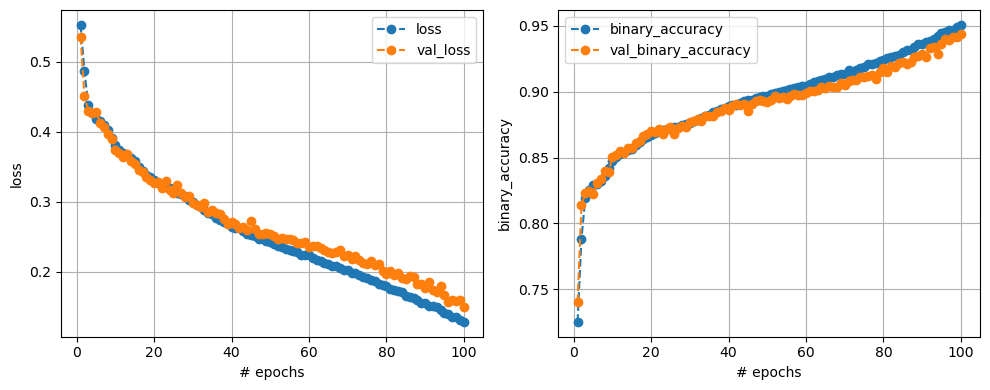

151/151 [==============================] - 2s 16ms/step - loss: 0.1282 - binary_accuracy: 0.9508 - val_loss: 0.1497 - val_binary_accuracy: 0.9441 - lr: 0.0010

Tiempo total de entranamiento: 251.24 segundos


In [51]:
#Entreno del modelo:
history_lstm = lstm_model.fit(X_train, Y_train, batch_size=256, epochs=100,
                                validation_data=(X_val, Y_val),
                              callbacks=[timer_callback, plot_callback, lrreduce_callback])

In [52]:
epochs_trained_lstm = len(history_lstm.history['loss'])

In [53]:
# Evaluo el modelo con los datos de test:
loss_lstm, acc_lstm = lstm_model.evaluate(X_test, Y_test)
print(f"Test loss: {loss_lstm:.4f}, Test accuracy: {acc_lstm:.4f}")

151/151 [==============================] - 1s 5ms/step - loss: 0.1489 - binary_accuracy: 0.9429
Test loss: 0.1489, Test accuracy: 0.9429


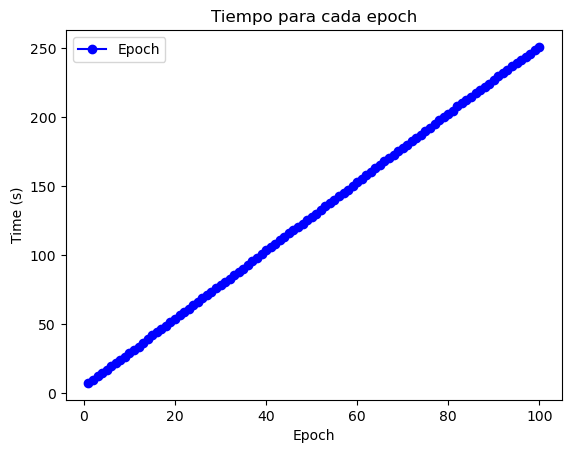

Tiempo total de training: 251.24 segundos


In [54]:
#Grafico del tiempo por las epocas:
plot_epoch_times(timer_callback)

# Tiempo total del training: 
tiempo_total_lstm = round(timer_callback.total_time,2)
print(f"Tiempo total de training: {tiempo_total_lstm} segundos")

# Guardo el modelo
lstm_model.save('lstm_model.h5')

Podemos observar que la performance del modelo ha mejorado con respecto al modelo de dos capas GRU pero el accuracy no ha alcanzado el valor más alto que obtuvimos con el modelo de una única capa GRU. En este caso el valor de accuracy fue de 0.94. 
En cuanto a los parámetro entrenables, han aumentado a 29989 y el tiempo de entrenamiento fue de 244 segundos.  
Por lo tanto, el modelo no performa mejor que el de una única capa GRU.

# 3. Elección del mejor modelo y *fine tuning* 

En el apartado anterior ya hemos probado varios tipos de modelos diferentes. Ahora, basados en el rendimiento, complejidad (número de parámetros) y tiempo de entrenamiento, debemos escoger el tipo de modelo que mejor se adecua a nuestro problema. 

## 3.1 Comparación de modelos

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
Realiza y responde las siguientes cuestiones:</p>
  <ul>
    <li>Haz una tabla comparativa para todos los modelos y arquitecturas usadas comparando el rendimiento, el número de parámetros y el tiempo por época (time/epoch)</li>
    <li>Justifica la elección de un modelo</li>
  </ul>
</div>

In [55]:
from prettytable import PrettyTable

# Creo un objeto PrettyTable
table = PrettyTable()

# Columnas
table.field_names = ["Model","Trainable parameters", "Time per Epoch", "Validation Accuracy"]

# Filas
table.add_row(["Simple RNN", trainable_params_simpleRNN,round(tiempo_total_simpleRNN/epochs_trained_RNN,2), round(acc_simpleRNN,2)])
table.add_row(["GRU", trainable_params_gru,round(tiempo_total_gru/epochs_trained_gru,2), round(acc_gru,2)])
table.add_row(["Two layer GRU", trainable_params_gru2,round(tiempo_total_gru2/epochs_trained_gru2,2), round(acc_gru2,2)])
table.add_row(["Two layer LSTM", trainable_params_lstm,round(tiempo_total_lstm/epochs_trained_lstm,2), round(acc_lstm,2)])

print(table)

+----------------+----------------------+----------------+---------------------+
|     Model      | Trainable parameters | Time per Epoch | Validation Accuracy |
+----------------+----------------------+----------------+---------------------+
|   Simple RNN   |        17541         |     12.68      |         0.73        |
|      GRU       |        13573         |      1.77      |         0.95        |
| Two layer GRU  |        22821         |      2.37      |         0.85        |
| Two layer LSTM |        29989         |      2.51      |         0.94        |
+----------------+----------------------+----------------+---------------------+


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Comentarios:</strong></p>
<p>
    Analizando la tabla vemos que el modelo con mejor performance es el GRU de una capa, con el cual obtuvimos un accuracy de 0,95 y el tiempo de entrenamiento por época es de 1.7 segundos, el menor de todos, lo cual está relacionado con que es el modelo con la menor cantidad de parámetros a entrenar.
</p>
</div>

## 3.2 *Fine Tuning* de parámetros para el modelo elegido

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
 Para realizar una elección de parámetros que optimize los resultados utilizaremos la librería <code>keras-tuner</code>. El primer paso con una librería nueva es consultar la documentación y familiarizarse con ejemplos básicos.</p>
<p>Los parámetros que eligiremos para el ajuste son:</p>
  <ul>
    <li><strong>Unidades de la primera capa</strong>. Variarán entre 16 y 64 con steps de 16.</li>
    <li>Añadiremos <strong>dropout en la segunda capa</strong> y los valores serán: 0, 0.1, 0.25 y 0.7 </li>
    <li><strong>Learning rate</strong> que podrá tomar los siguientes valores: 1e-2, 5e-3 y 1e-3</li>
  </ul>
<p>Finalmente, usaremos el método de <code>Hyperband</code> cuyo objetivo será optimizar la <i>accuracy</i> de validación.</p>
</div>

In [56]:
#------------------------------#
#    INSTALAMOS KERAS-TUNER    #
#------------------------------#

#!pip install -q -U keras-tuner
import keras_tuner as kt

In [57]:
from keras_tuner.tuners import Hyperband

# Defino una funcion que crea y devuelve un modelo keras:
def build_model(hp):
    model = Sequential()
    model.add(GRU(units=hp.Int('units', min_value=16, max_value=64, step=16),
                  activation = 'tanh',recurrent_activation='sigmoid'))
    model.add(Dense(5, activation='sigmoid'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 5e-3, 1e-3])),
                  loss='binary_crossentropy', metrics=['binary_accuracy'])
    return model

# Inicializo el tuner: 
#KerasTuner is an easy-to-use, scalable hyperparameter optimization framework that solves the pain points of hyperparameter search
tuner = Hyperband(build_model,
                  objective='val_binary_accuracy',
                  max_epochs=100
                 )

# Empieza la busqueda de los mejores hiperparametros:
tuner.search(X_train, Y_train,
             epochs=100,
             validation_data=(X_val, Y_val))
             
# Obtengo los mejores hiperparametros y construyo un modelo con ellos:
best_hps = tuner.get_best_hyperparameters(num_trials=3)[0]
final_model = build_model(best_hps)
final_model

Trial 12 Complete [00h 00m 20s]
val_binary_accuracy: 0.894559919834137

Best val_binary_accuracy So Far: 0.9250832200050354
Total elapsed time: 00h 04m 18s


## 3.3 Entrenamiento del modelo con los hiperparámetros tuneados

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
Tal como hicimos en la sección 2 con otro modelos, entrena el modelo final para la clasificación durante 100 epochs usando los parámetros obtenidos en el apartado anterior, <code>EarlyStoping</code> con una <i>patience</i> de 5 epochs, pero ahora sin el callback para reducir el <i>learning rate</i>.</p>
<p>Calcula el <i>accuracy</i> sobre el grupo de test y el tiempo total de entrenamiento.</p>
</div>

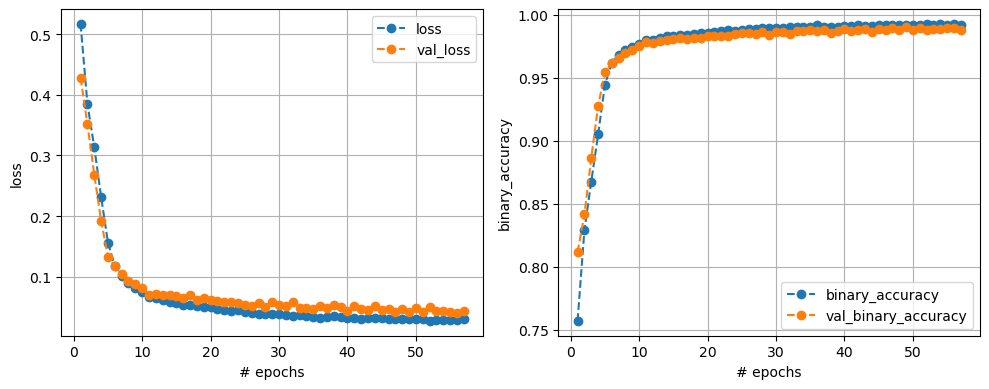

151/151 [==============================] - 2s 12ms/step - loss: 0.0309 - binary_accuracy: 0.9918 - val_loss: 0.0434 - val_binary_accuracy: 0.9883

Tiempo total de entranamiento: 100.09 segundos


In [58]:
#Entreno el modelo final:
history_tuned_gru = final_model.fit(X_train, Y_train, batch_size=256, epochs=100,
                                validation_data=(X_val, Y_val), 
                              callbacks=[timer_callback, plot_callback, earlystop_callback])

In [59]:
epochs_trained_tuned_gru = len(history_tuned_gru.history['loss'])

In [60]:
# Evaluo el modelo con los datos de test:
loss_tuned_gru, acc_tuned_gru= final_model.evaluate(X_test, Y_test)
print(f"Test loss: {loss_tuned_gru:.4f}, Test accuracy: {acc_tuned_gru:.4f}")

151/151 [==============================] - 1s 3ms/step - loss: 0.0456 - binary_accuracy: 0.9880
Test loss: 0.0456, Test accuracy: 0.9880


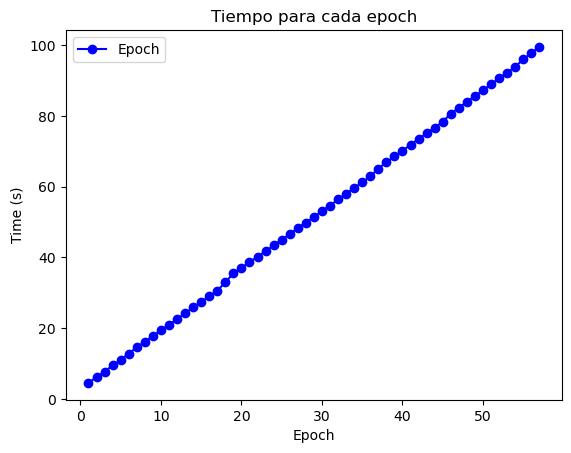

Tiempo total de training: 100.09 segundos


In [61]:
#Grafico del tiempo por las epocas:
plot_epoch_times(timer_callback)

# Tiempo total del training:
tiempo_total_tuned_gru = round(timer_callback.total_time,2)
print(f"Tiempo total de training: {tiempo_total_tuned_gru} segundos")

# Guardo el modelo
final_model.save('tuned_gru.h5')

Los valores obtenidos han mejorado con respecto al mejor modelo, el de una única capa GRU, el accuracy aumentó a 0.988 y el tiempo de entrenamiento fue muy bajo, 100 segundos para aprox 60 épocas.

## 4.1 Definiendo un nuevo modelo para la localización de los errores

Para encontrar cuándo ocurre un error en la lectura de un sensor, una secuencia determinada se dividirá en segmentos y la clasificación se realizará en cada segmento individualmente. Para ello, hay que definir un nuevo modelo que divida la señal de entrada y estas partes se le pasarán al siguiente _layer_ donde se usará el clasificador que ya hemos entrenado anteriormente.

# 4. Localización de los errores

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
 Definir un nuevo modelo que constará de las siguientes capas (layers): </p>
  <ul>
    <li>  <code>Reshape</code> para cortar la entrada en sub-secuencias de 10 </li>
    <li>  Una capa con el clasificador anterior <code>best_model</code></li>
    <li>  Una capa final que nos permita obtener el máximo de las capas anteriores y poder comparar con los datos de entrenamiento</li>
  </ul>
<p> Entrena este modelo por 100 epochs usando, como siempre, EarlyStoping. Comenta los resultados y si realmente tiene sentido volver a entrenar con los mismos datos <code>x_train</code> de los que disponemos.</p>
</div>

In [62]:
# Define the reshape layer to cut the input into sub-sequences of 10

new_model = Sequential()
#Uso la capa Reshape para modificar los datos de entrada que tenian un tamaño de (90,3) a un tamaño de (9,10,3)
#Es decir primero cada lectura consiste en un array de 90 arrays de 3 elementos, ahora esos 90 arrays estan separados en 9 diferentes
new_model.add(Reshape((9, 10, 3), input_shape=(90,3)))
#Defino la capa TimeDistributed que va a utilizar el modelo definido anteriormente
new_model.add(TimeDistributed(final_model))
#Usamos la capa GlobalMaxPool1D para obtener las caracteristicas mas importantes
new_model.add(GlobalMaxPool1D())
#Definimos la capa de salida:
new_model.add(Dense(5, activation='sigmoid'))

# Compilamos el modelo
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['binary_accuracy'])

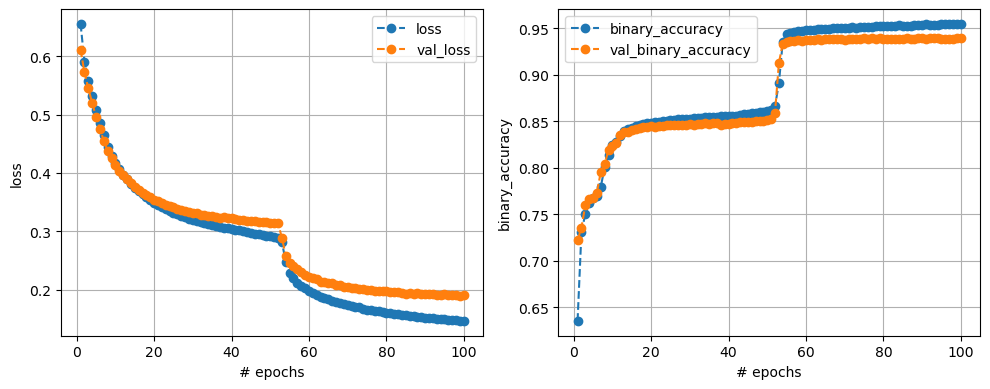

151/151 [==============================] - 2s 11ms/step - loss: 0.1466 - binary_accuracy: 0.9545 - val_loss: 0.1902 - val_binary_accuracy: 0.9390

Tiempo total de entranamiento: 154.08 segundos


In [63]:
#Entreno el modelo: 
history_new_model = new_model.fit(X_train, Y_train, batch_size=256, epochs=100,
                            validation_data=(X_val, Y_val), 
                            callbacks=[timer_callback, plot_callback, earlystop_callback])

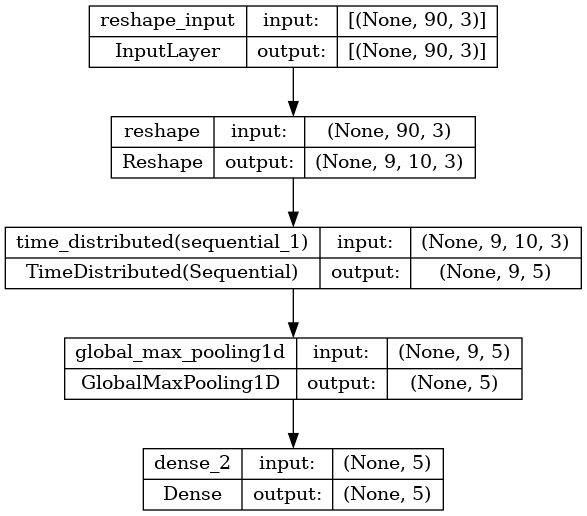

In [64]:
tf.keras.utils.plot_model(new_model,show_shapes=True)

In [65]:
# Evaluo el modelo con los datos de test:
loss_new_model, acc_new_model= new_model.evaluate(X_test, Y_test)
print(f"Test loss: {loss_new_model:.4f}, Test accuracy: {acc_new_model:.4f}")

151/151 [==============================] - 1s 3ms/step - loss: 0.1844 - binary_accuracy: 0.9404
Test loss: 0.1844, Test accuracy: 0.9404


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Comenta, además, que efectos tiene en la localización el hecho de hacer un reshape para tener N=10 sub-secuencias. Si hubieramos elegido N=1, 2 o 5, ¿qué cambiaría? </strong></p>
<p>
   El accuracy obtenido es 0.94, un poco menos que el que habíamos logrado con el modelo anterior, siendo la diferencia entre ambos el tamaño del input que reciben, la reducción de la performance de este modelo en comparación con el anterior puede deberse a que al no ver toda la secuencia de datos de cada lectura, el modelo no puede identificar los errores que aparecen distribuidos en toda la secuencia, es decir al cortar la lectura el modelo no está identificando correctamente las cinco clases de errores como si lo hacía cuando los datos de entrada eran la secuencia completa.
   <br>
    Creo que si elegiríamos sub-secuencias más chicas el resultado sería aún peor, porque para detectar los errores el modelo necesita tener la mayor parte de la lectura. 
</p>
</div>

## 4.2 Modelo de localización de errores

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
 El modelo anterior devuelve predicciones para la secuencia completa, pero para poder localizar los errores necesitaremos las predicciones para cada sub-secuencia y, por lo tanto, definiremos un nuevo modelo, <code>loc_model</code>, igual al anterior, pero obviando el último layer.</p>
<p>Explica el resultado obtenido usando un dato de test como ejemplo.</p>
</div>

In [66]:
#Defino el loc_model:
loc_model = Sequential()
loc_model.add(Reshape((9, 10, 3), input_shape=(90,3)))
loc_model.add(TimeDistributed(final_model))
loc_model.add(Dense(5, activation='sigmoid'))

In [67]:
# Compilo el modelo:
loc_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['binary_accuracy'])

In [68]:
#Modifico el shape de los labels para poder entrenar el modelo:
Y_test_reshape = np.repeat(Y_test[:, np.newaxis, :], 9, axis=1)
Y_train_reshape = np.repeat(Y_train[:, np.newaxis, :], 9, axis=1)
Y_val_reshape = np.repeat(Y_val[:, np.newaxis, :], 9, axis=1)

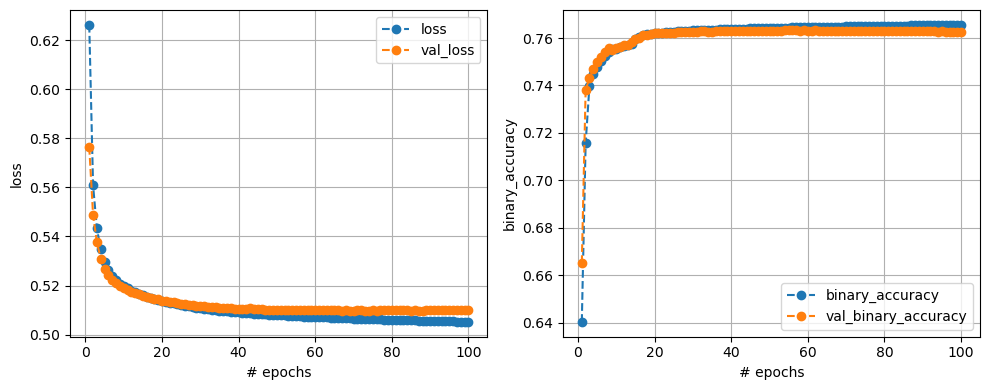

151/151 [==============================] - 1s 10ms/step - loss: 0.5052 - binary_accuracy: 0.7655 - val_loss: 0.5100 - val_binary_accuracy: 0.7627

Tiempo total de entranamiento: 162.70 segundos


In [69]:
#Entreno del modelo:
history_loc_model = loc_model.fit(X_train, Y_train_reshape, batch_size=256, epochs=100,
                                validation_data=(X_val, Y_val_reshape), 
                            callbacks=[timer_callback, plot_callback, earlystop_callback])

In [70]:
# Evaluo el modelo con los datos de test:
loss_loc_model, acc_loc_model= loc_model.evaluate(X_test, Y_test_reshape)
print(f"Test loss: {loss_loc_model:.4f}, Test accuracy: {acc_loc_model:.4f}")

151/151 [==============================] - 1s 4ms/step - loss: 0.5111 - binary_accuracy: 0.7619
Test loss: 0.5111, Test accuracy: 0.7619


In [71]:
Y_test_reshape[0:1]

array([[[0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1]]])

In [72]:
# Predicciones para una muestra del set de test:
loc_model.predict(X_test[0:1])

1/1 [==============================] - 1s 806ms/step


array([[[0.16134074, 0.25219598, 0.09043071, 0.28230125, 0.41281903],
        [0.17342933, 0.24287151, 0.09443706, 0.29540232, 0.39892244],
        [0.16457331, 0.27159768, 0.08832993, 0.30108377, 0.39757884],
        [0.17047498, 0.244243  , 0.09374977, 0.29677585, 0.4131038 ],
        [0.16350965, 0.2512855 , 0.0903353 , 0.28441805, 0.41089916],
        [0.16166052, 0.24956867, 0.09009333, 0.28421807, 0.41230404],
        [0.165034  , 0.24679764, 0.09392808, 0.30161065, 0.40999618],
        [0.16870743, 0.20589846, 0.09298242, 0.31185043, 0.98573744],
        [0.16493894, 0.24620424, 0.09219899, 0.2907074 , 0.41109422]]],
      dtype=float32)

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Comentarios:</strong></p>
<p>
    Las predicciones del modelo loc_model de una lectura de X_test de tamaño (90,3) devuelven 9 arrays, ya que este modelo divide la lectura en subsecuencias, cada uno de estos arrays contiene predicciones para cada una de las clases, tomando como referencia los labels reales de la muestra seleccionada: [0,0,0,0,1], vemos que las predicciones en todas las secuencias la probabilidad más alta se encuentra en el último elemento del array, lo indicaría que la predicción la realizó de forma correcta para esta muestra. 
    El accuracy obtenido para este modelo es de 0.76.
</p>
</div>

## 5. Visualización de los errores  (1 punto)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
Diseña una función que reciba una lectura de los sensores y su label, y que devuelva una gráfica con:</p>
    <ul>
    <li>  La lectura de los sensores.</li>
    <li>  Una banda vertical en la sub-secuencia donde se encuentra cada error. Habrá tantas bandas verticales como errores existan en la lectura.</li>
    <li>  Las bandas indicando errores deberán tener un color asociado a cada tipo de error y el <code>alpha</code> usado para pintar esa región será proporcional a la confianza en la clasificación de ese error.</li>
  </ul>
  <p>Además, informa de los errores detectados y los reales por pantalla. Usa esta función para visualizar 10 lecturas diferentes. ¿Qué color hace referencia al error producido por el paso del metro?</p>
</div>

In [73]:
# Puedes usar estos colores para cada identificar los diferentes tipos de errores
color_errores = {1: 'tab:red', 2: 'tab:purple', 3: 'tab:brown', 4: 'tab:cyan', 5: 'tab:olive'}

In [78]:
def plot_sensor_reading(sensor_reading, label):
    
    nombre_sensores = ['Sensor 1', 'Sensor 2', 'Sensor 3']
    plt.plot(sensor_reading[0], label=nombre_sensores)
    plt.legend(loc='lower right')
   
    
    predict_label = loc_model.predict(sensor_reading)
    predicted_indices = np.where(predict_label >0.5, 1, 0)

    axis = 0
    for row in range(9):
        for col in range(5):
            axis = axis + 2
            if predicted_indices[0,row][col] == 1:
                # Get the color for this row
                color = color_errores[col+1]
                # Plot a vertical line with the corresponding color
                plt.axvline(x=axis, color=color, alpha=predict_label[0,row][col])
            
    plt.title('Lectura de sensores')
    plt.show()
    
    #Informe de errores:
    #Errores reales:
    true_indices = np.where(label[0])[0]+1
    print('Los errores reales en la lectura son de clase:',true_indices)

    #Errores que detecto el modelo:
    predicted_errors = []
    for i in range(0,len(predicted_indices[0])):
        predicted_errors.append(np.where(predicted_indices[0][i])[0]+1)
    for j,errores in enumerate(predicted_errors):
        print('\nLos errores que el modelo predijo en la sub secuencia ',j+1, 'son de clase:', errores)


1/1 [==============================] - 0s 28ms/step


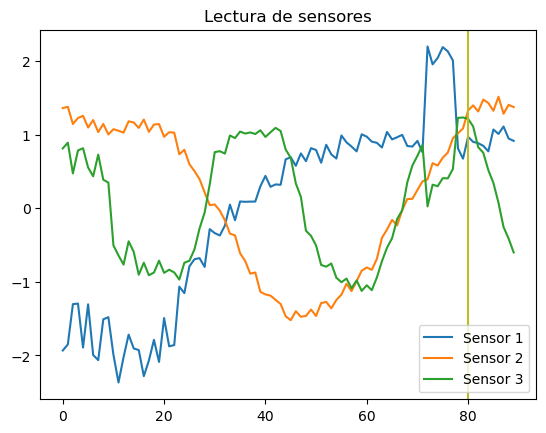

Los errores reales en la lectura son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  1 son de clase: []

Los errores que el modelo predijo en la sub secuencia  2 son de clase: []

Los errores que el modelo predijo en la sub secuencia  3 son de clase: []

Los errores que el modelo predijo en la sub secuencia  4 son de clase: []

Los errores que el modelo predijo en la sub secuencia  5 son de clase: []

Los errores que el modelo predijo en la sub secuencia  6 son de clase: []

Los errores que el modelo predijo en la sub secuencia  7 son de clase: []

Los errores que el modelo predijo en la sub secuencia  8 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  9 son de clase: []
1/1 [==============================] - 0s 29ms/step


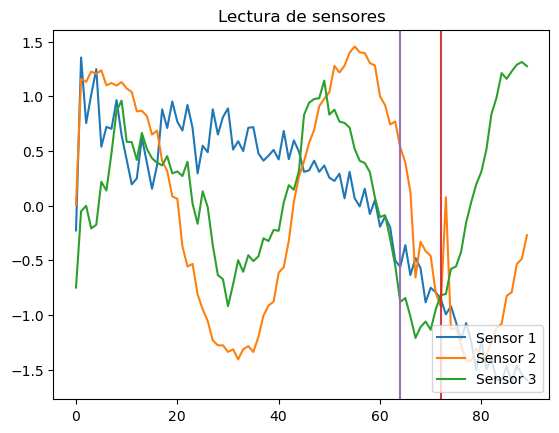

Los errores reales en la lectura son de clase: [1 2]

Los errores que el modelo predijo en la sub secuencia  1 son de clase: []

Los errores que el modelo predijo en la sub secuencia  2 son de clase: []

Los errores que el modelo predijo en la sub secuencia  3 son de clase: []

Los errores que el modelo predijo en la sub secuencia  4 son de clase: []

Los errores que el modelo predijo en la sub secuencia  5 son de clase: []

Los errores que el modelo predijo en la sub secuencia  6 son de clase: []

Los errores que el modelo predijo en la sub secuencia  7 son de clase: [2]

Los errores que el modelo predijo en la sub secuencia  8 son de clase: [1]

Los errores que el modelo predijo en la sub secuencia  9 son de clase: []
1/1 [==============================] - 0s 29ms/step


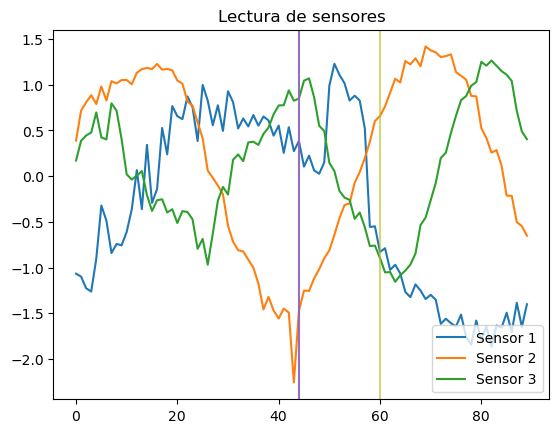

Los errores reales en la lectura son de clase: [2 4]

Los errores que el modelo predijo en la sub secuencia  1 son de clase: []

Los errores que el modelo predijo en la sub secuencia  2 son de clase: []

Los errores que el modelo predijo en la sub secuencia  3 son de clase: []

Los errores que el modelo predijo en la sub secuencia  4 son de clase: []

Los errores que el modelo predijo en la sub secuencia  5 son de clase: [2]

Los errores que el modelo predijo en la sub secuencia  6 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  7 son de clase: []

Los errores que el modelo predijo en la sub secuencia  8 son de clase: []

Los errores que el modelo predijo en la sub secuencia  9 son de clase: []
1/1 [==============================] - 0s 26ms/step


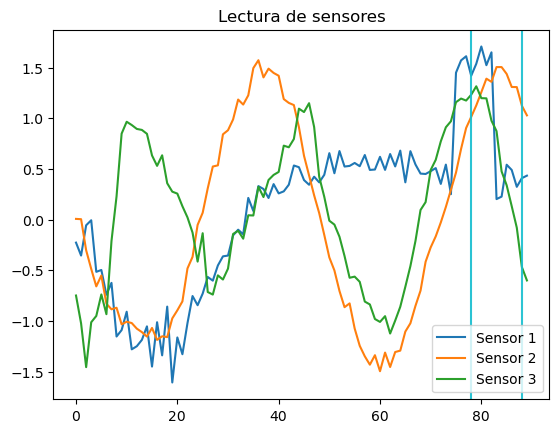

Los errores reales en la lectura son de clase: [4]

Los errores que el modelo predijo en la sub secuencia  1 son de clase: []

Los errores que el modelo predijo en la sub secuencia  2 son de clase: []

Los errores que el modelo predijo en la sub secuencia  3 son de clase: []

Los errores que el modelo predijo en la sub secuencia  4 son de clase: []

Los errores que el modelo predijo en la sub secuencia  5 son de clase: []

Los errores que el modelo predijo en la sub secuencia  6 son de clase: []

Los errores que el modelo predijo en la sub secuencia  7 son de clase: []

Los errores que el modelo predijo en la sub secuencia  8 son de clase: [4]

Los errores que el modelo predijo en la sub secuencia  9 son de clase: [4]
1/1 [==============================] - 0s 30ms/step


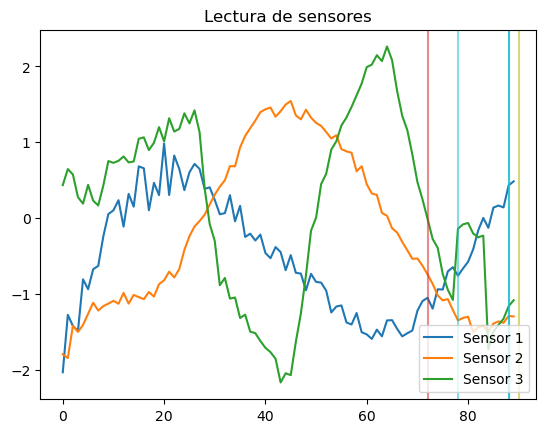

Los errores reales en la lectura son de clase: [3]

Los errores que el modelo predijo en la sub secuencia  1 son de clase: []

Los errores que el modelo predijo en la sub secuencia  2 son de clase: []

Los errores que el modelo predijo en la sub secuencia  3 son de clase: []

Los errores que el modelo predijo en la sub secuencia  4 son de clase: []

Los errores que el modelo predijo en la sub secuencia  5 son de clase: []

Los errores que el modelo predijo en la sub secuencia  6 son de clase: []

Los errores que el modelo predijo en la sub secuencia  7 son de clase: []

Los errores que el modelo predijo en la sub secuencia  8 son de clase: [1 4]

Los errores que el modelo predijo en la sub secuencia  9 son de clase: [4 5]
1/1 [==============================] - 0s 27ms/step


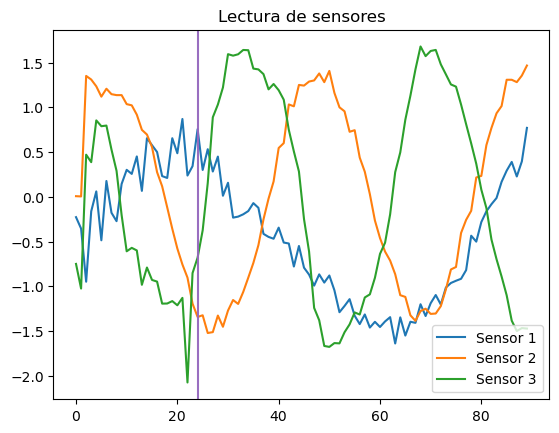

Los errores reales en la lectura son de clase: [2]

Los errores que el modelo predijo en la sub secuencia  1 son de clase: []

Los errores que el modelo predijo en la sub secuencia  2 son de clase: []

Los errores que el modelo predijo en la sub secuencia  3 son de clase: [2]

Los errores que el modelo predijo en la sub secuencia  4 son de clase: []

Los errores que el modelo predijo en la sub secuencia  5 son de clase: []

Los errores que el modelo predijo en la sub secuencia  6 son de clase: []

Los errores que el modelo predijo en la sub secuencia  7 son de clase: []

Los errores que el modelo predijo en la sub secuencia  8 son de clase: []

Los errores que el modelo predijo en la sub secuencia  9 son de clase: []
1/1 [==============================] - 0s 26ms/step


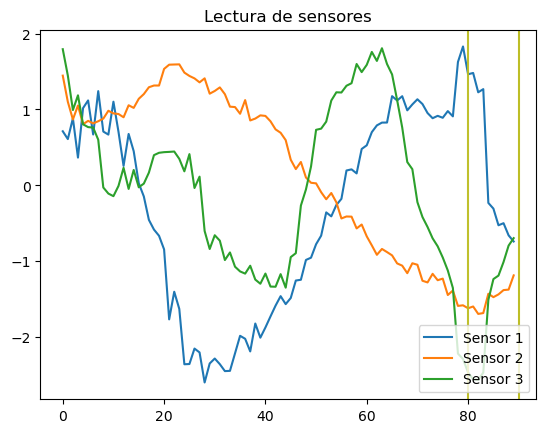

Los errores reales en la lectura son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  1 son de clase: []

Los errores que el modelo predijo en la sub secuencia  2 son de clase: []

Los errores que el modelo predijo en la sub secuencia  3 son de clase: []

Los errores que el modelo predijo en la sub secuencia  4 son de clase: []

Los errores que el modelo predijo en la sub secuencia  5 son de clase: []

Los errores que el modelo predijo en la sub secuencia  6 son de clase: []

Los errores que el modelo predijo en la sub secuencia  7 son de clase: []

Los errores que el modelo predijo en la sub secuencia  8 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  9 son de clase: [5]
1/1 [==============================] - 0s 25ms/step


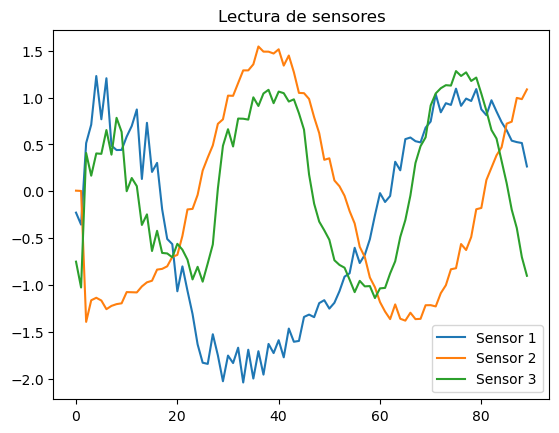

Los errores reales en la lectura son de clase: []

Los errores que el modelo predijo en la sub secuencia  1 son de clase: []

Los errores que el modelo predijo en la sub secuencia  2 son de clase: []

Los errores que el modelo predijo en la sub secuencia  3 son de clase: []

Los errores que el modelo predijo en la sub secuencia  4 son de clase: []

Los errores que el modelo predijo en la sub secuencia  5 son de clase: []

Los errores que el modelo predijo en la sub secuencia  6 son de clase: []

Los errores que el modelo predijo en la sub secuencia  7 son de clase: []

Los errores que el modelo predijo en la sub secuencia  8 son de clase: []

Los errores que el modelo predijo en la sub secuencia  9 son de clase: []
1/1 [==============================] - 0s 25ms/step


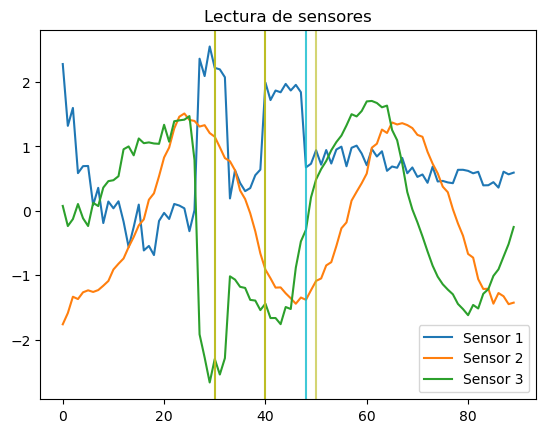

Los errores reales en la lectura son de clase: [4 5]

Los errores que el modelo predijo en la sub secuencia  1 son de clase: []

Los errores que el modelo predijo en la sub secuencia  2 son de clase: []

Los errores que el modelo predijo en la sub secuencia  3 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  4 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  5 son de clase: [4 5]

Los errores que el modelo predijo en la sub secuencia  6 son de clase: []

Los errores que el modelo predijo en la sub secuencia  7 son de clase: []

Los errores que el modelo predijo en la sub secuencia  8 son de clase: []

Los errores que el modelo predijo en la sub secuencia  9 son de clase: []
1/1 [==============================] - 0s 25ms/step


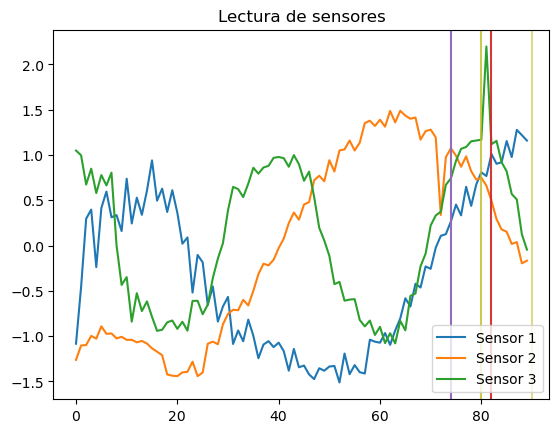

Los errores reales en la lectura son de clase: [1 2]

Los errores que el modelo predijo en la sub secuencia  1 son de clase: []

Los errores que el modelo predijo en la sub secuencia  2 son de clase: []

Los errores que el modelo predijo en la sub secuencia  3 son de clase: []

Los errores que el modelo predijo en la sub secuencia  4 son de clase: []

Los errores que el modelo predijo en la sub secuencia  5 son de clase: []

Los errores que el modelo predijo en la sub secuencia  6 son de clase: []

Los errores que el modelo predijo en la sub secuencia  7 son de clase: []

Los errores que el modelo predijo en la sub secuencia  8 son de clase: [2 5]

Los errores que el modelo predijo en la sub secuencia  9 son de clase: [1 5]


In [79]:
for i in range(10):
    sensor_reading = X_test[i:i+1]
    label = Y_test[i:i+1]
    plot_sensor_reading(sensor_reading, label)

Habiendo elegido un valor umbral de 0.5 para clasificar las probabilidades del modelo en 1 o 0,  vemos no hay un color que se repita a lo largo de todas las secuencias de una misma lectura. Lo que esperaba era que el error que se produce a consecuencia del paso del metro cercano al laboratorio afecte a toda la lectura, es decir tendría que aparecer en todas las secuencias de la medición, pero tomando 0.5 como umbral para la clasificación no está apareciendo.
A continuación haré las mismas gráficas pero bajando el umbral de clasificación a 0.4 para observar los resultados:

In [80]:
def plot_sensor_reading(sensor_reading, label):
    
    nombre_sensores = ['Sensor 1', 'Sensor 2', 'Sensor 3']
    plt.plot(sensor_reading[0], label=nombre_sensores)
    plt.legend(loc='lower right')
   
    
    predict_label = loc_model.predict(sensor_reading)
    predicted_indices = np.where(predict_label >0.4, 1, 0)

    axis = 0
    for row in range(9):
        for col in range(5):
            axis = axis + 2
            if predicted_indices[0,row][col] == 1:
                # Get the color for this row
                color = color_errores[col+1]
                # Plot a vertical line with the corresponding color
                plt.axvline(x=axis, color=color, alpha=predict_label[0,row][col])
            
    plt.title('Lectura de sensores')
    plt.show()
    
    #Informe de errores:
    #Errores reales:
    true_indices = np.where(label[0])[0]+1
    print('Los errores reales en la lectura son de clase:',true_indices)

    #Errores que detecto el modelo:
    predicted_errors = []
    for i in range(0,len(predicted_indices[0])):
        predicted_errors.append(np.where(predicted_indices[0][i])[0]+1)
    for j,errores in enumerate(predicted_errors):
        print('\nLos errores que el modelo predijo en la sub secuencia ',j+1, 'son de clase:', errores)


1/1 [==============================] - 0s 28ms/step


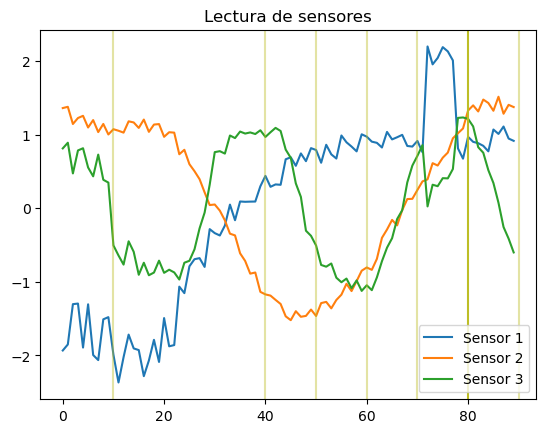

Los errores reales en la lectura son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  1 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  2 son de clase: []

Los errores que el modelo predijo en la sub secuencia  3 son de clase: []

Los errores que el modelo predijo en la sub secuencia  4 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  5 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  6 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  7 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  8 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  9 son de clase: [5]
1/1 [==============================] - 0s 25ms/step


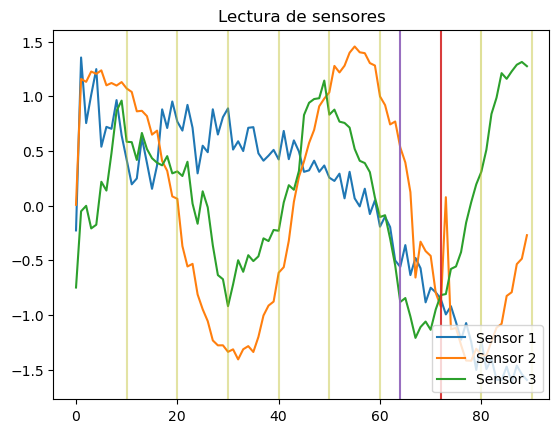

Los errores reales en la lectura son de clase: [1 2]

Los errores que el modelo predijo en la sub secuencia  1 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  2 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  3 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  4 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  5 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  6 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  7 son de clase: [2]

Los errores que el modelo predijo en la sub secuencia  8 son de clase: [1 5]

Los errores que el modelo predijo en la sub secuencia  9 son de clase: [5]
1/1 [==============================] - 0s 37ms/step


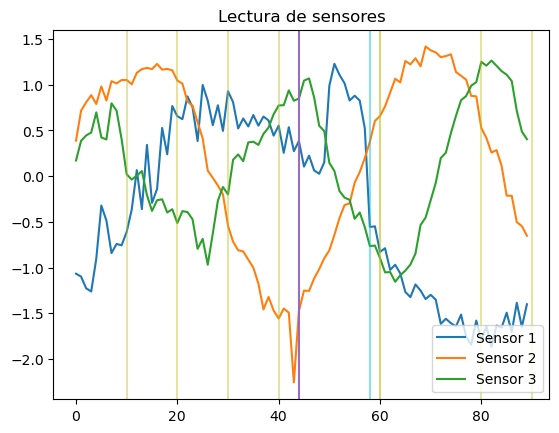

Los errores reales en la lectura son de clase: [2 4]

Los errores que el modelo predijo en la sub secuencia  1 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  2 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  3 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  4 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  5 son de clase: [2]

Los errores que el modelo predijo en la sub secuencia  6 son de clase: [4 5]

Los errores que el modelo predijo en la sub secuencia  7 son de clase: []

Los errores que el modelo predijo en la sub secuencia  8 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  9 son de clase: [5]
1/1 [==============================] - 0s 30ms/step


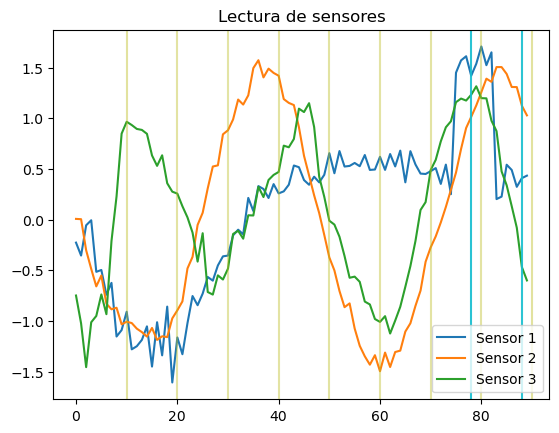

Los errores reales en la lectura son de clase: [4]

Los errores que el modelo predijo en la sub secuencia  1 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  2 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  3 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  4 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  5 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  6 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  7 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  8 son de clase: [4 5]

Los errores que el modelo predijo en la sub secuencia  9 son de clase: [4 5]
1/1 [==============================] - 0s 27ms/step


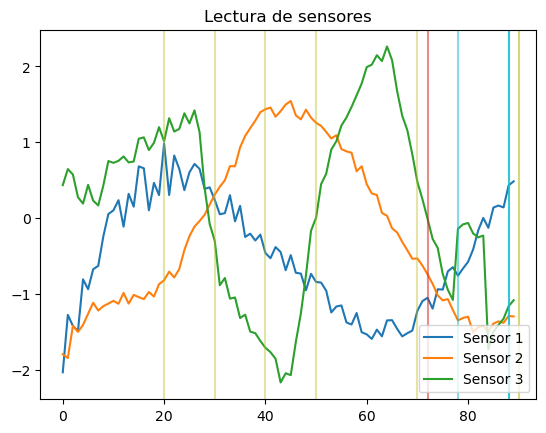

Los errores reales en la lectura son de clase: [3]

Los errores que el modelo predijo en la sub secuencia  1 son de clase: []

Los errores que el modelo predijo en la sub secuencia  2 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  3 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  4 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  5 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  6 son de clase: []

Los errores que el modelo predijo en la sub secuencia  7 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  8 son de clase: [1 4]

Los errores que el modelo predijo en la sub secuencia  9 son de clase: [4 5]
1/1 [==============================] - 0s 28ms/step


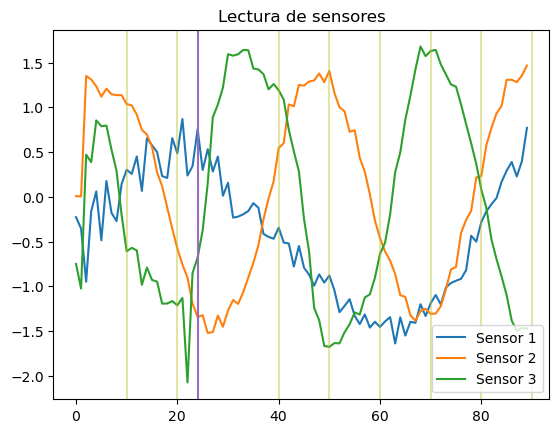

Los errores reales en la lectura son de clase: [2]

Los errores que el modelo predijo en la sub secuencia  1 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  2 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  3 son de clase: [2]

Los errores que el modelo predijo en la sub secuencia  4 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  5 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  6 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  7 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  8 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  9 son de clase: [5]
1/1 [==============================] - 0s 28ms/step


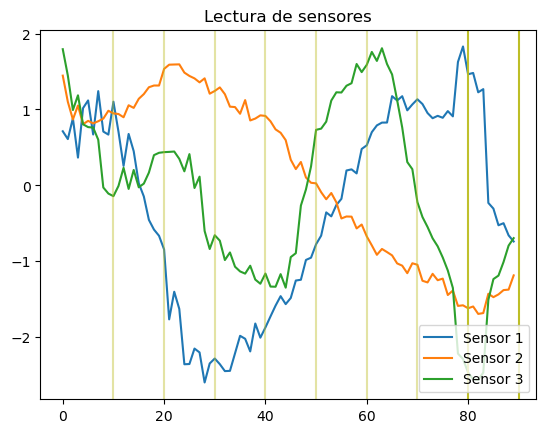

Los errores reales en la lectura son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  1 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  2 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  3 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  4 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  5 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  6 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  7 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  8 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  9 son de clase: [5]
1/1 [==============================] - 0s 26ms/step


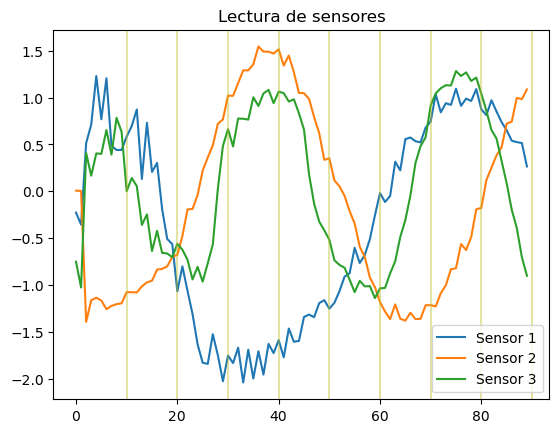

Los errores reales en la lectura son de clase: []

Los errores que el modelo predijo en la sub secuencia  1 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  2 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  3 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  4 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  5 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  6 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  7 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  8 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  9 son de clase: [5]
1/1 [==============================] - 0s 23ms/step


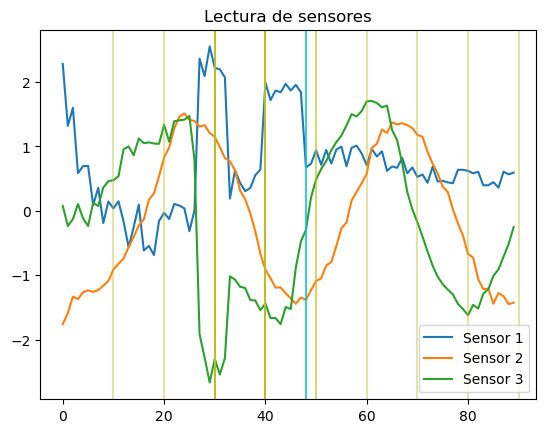

Los errores reales en la lectura son de clase: [4 5]

Los errores que el modelo predijo en la sub secuencia  1 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  2 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  3 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  4 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  5 son de clase: [4 5]

Los errores que el modelo predijo en la sub secuencia  6 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  7 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  8 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  9 son de clase: [5]
1/1 [==============================] - 0s 24ms/step


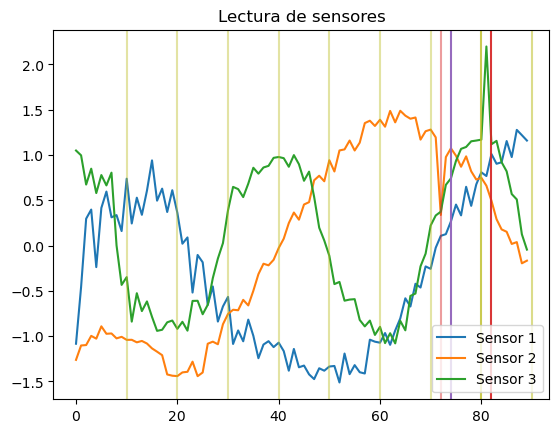

Los errores reales en la lectura son de clase: [1 2]

Los errores que el modelo predijo en la sub secuencia  1 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  2 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  3 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  4 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  5 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  6 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  7 son de clase: [5]

Los errores que el modelo predijo en la sub secuencia  8 son de clase: [1 2 5]

Los errores que el modelo predijo en la sub secuencia  9 son de clase: [1 5]


In [81]:
for i in range(10):
    sensor_reading = X_test[i:i+1]
    label = Y_test[i:i+1]
    plot_sensor_reading(sensor_reading, label)

En este caso vemos que el error de color verde oliva es el que se repite en la mayoría de las secuencias de cada lectura. Pero, el modelo no está funcionando de forma óptima porque agrega el error de clase 5 aunque no esté en los datos reales.
Pero, dado que es el comportamiento que esperaba, considero que el error de clase 5 es el causado por el metro.